In [ ]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

In [ ]:
# Only needed when running the notebook in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
# Data augmentation and normalization for training (For normalization use mean calculated on the ImageNet Dataset)
# Data augmentation includes random resized crop, horizontal flip, colorJitter (Randomly change the brightness, contrast and saturation of the image).
# The image is also normalized
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), # CenterCrop and normalize for validation
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Data folder of the dataset in google drive
data_dir = 'drive/MyDrive/Data LAMA/DatasetsSmall'
# paths for the training and validation dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# Batch size 4 is used for the small dataset! (Only 75 training inputs per class)
# Batch size was 64 for the big dataset with 1900 training inputs per class
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

#print(type(image_datasets)
# connect to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Luca_FS2', 'Luca_H2', 'Unknown2']


# Model

In [ ]:
from collections import OrderedDict
#Import the resnet18 model with its pretrained weights
model = models.resnet18(pretrained=True)
 
# As we don't want to change the network when optimzing (Resnet18 is already optimized), we will freeze the 
# parameters of the network
for param in model.parameters():
    param.requires_grad = False
    
# Replace the last fully convolutional layer of resnet (the input is a 512 & output is a 1000 1D Vector)
# model.fc.in_features will return the number of input features of the fully connected layer (512).
num_features = model.fc.in_features
print(num_features)
print(model.fc.out_features)
# Now replace the old fc network. First reduce dimensionality to 100, add ReLU and further recuce to 3 (Luca_H, Luca_FS and Unknown). Output is a Softmax Layer
model.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_features,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,3)),
    ('output', nn.Softmax(dim=1))]))
model = model.to(device)

# Using  SGD optimizer for the replaced fc-layer only!!! Rest of the network (ResNet18) 
# should not be changed. We use the default values for the optimizer (lr=0.001, betas=(0.9, 0.999), eps=1e-08)
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Reduce learning rate every 5 epochs by 0.1 (default value)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

512
1000


In [ ]:
# Loss function
loss_fct = nn.CrossEntropyLoss()


# Train model

In [ ]:
# It recieves the model, loss_function, optimizer and scheduler previously defined
def train_model(model, loss_fct, optimizer, scheduler, num_epochs=20):
    # Just needed to print the time needed for each epoch
    since = time.time()

    # Now we will first set the actual model as the best model. Later when running the epochs we will compare the best_network_wts
    # with the optimzed network. If the accuracy (compared to best_acc) is higher than the acc of the best_modell
    # the current model will become the new best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc_list_val = []
    loss_list_val = []
    acc_list_train = []
    loss_list_train = []
    best_epoch = 0

    # now run the epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data for this tarining/val phase of the epoch.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fct(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step() # does the update

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            # Calculate the average loss/ acc for this phase 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model if the accuracy is increased in this epoch (deepcopy, because we want to prevent to 
            # change the best_model_wts in the next epoch unintentionaly)
            if phase == 'val': 
                if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
                  best_epoch = epoch
                acc_list_val.append(epoch_acc)
                loss_list_val.append(epoch_loss)

            elif phase == 'train':
                loss_list_train.append(epoch_loss)
                acc_list_train.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    # Return the model with the best accuracy and statistics
    return model, acc_list_train, loss_list_train, acc_list_val, loss_list_val, best_epoch

Optimize the model

In [ ]:
import matplotlib.pyplot as plt
model, acc_list_train, loss_list_train, acc_list_val, loss_list_val, best_epoch = train_model(model, loss_fct, optimizer, lr_scheduler) # Optimzing the model with the default 20 epochs

# save the optimized model
path = 'drive/MyDrive/Data LAMA/model-face-recognition-dictSmallDataset.pth'
torch.save(model.state_dict(), path)

Epoch 0/19
----------
train Loss: 1.0860 Acc: 0.3849
val Loss: 1.0577 Acc: 0.3867

Epoch 1/19
----------
train Loss: 1.0544 Acc: 0.4812
val Loss: 0.9956 Acc: 0.5867

Epoch 2/19
----------
train Loss: 1.0015 Acc: 0.6402
val Loss: 0.9015 Acc: 0.9467

Epoch 3/19
----------
train Loss: 0.9433 Acc: 0.7741
val Loss: 0.8194 Acc: 0.8800

Epoch 4/19
----------
train Loss: 0.9064 Acc: 0.7531
val Loss: 0.7526 Acc: 0.9467

Epoch 5/19
----------
train Loss: 0.8621 Acc: 0.8201
val Loss: 0.7539 Acc: 0.9600

Epoch 6/19
----------
train Loss: 0.8555 Acc: 0.8285
val Loss: 0.7427 Acc: 0.9333

Epoch 7/19
----------
train Loss: 0.8529 Acc: 0.8452
val Loss: 0.7259 Acc: 0.9733

Epoch 8/19
----------
train Loss: 0.8419 Acc: 0.8577
val Loss: 0.7198 Acc: 0.9867

Epoch 9/19
----------
train Loss: 0.8470 Acc: 0.8033
val Loss: 0.7248 Acc: 0.9600

Epoch 10/19
----------
train Loss: 0.8132 Acc: 0.8828
val Loss: 0.7380 Acc: 0.9067

Epoch 11/19
----------
train Loss: 0.8270 Acc: 0.8661
val Loss: 0.7162 Acc: 0.9733

Ep

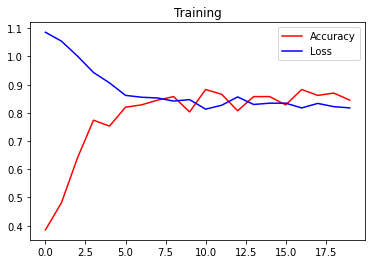

In [ ]:
x = [0, 1 , 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
plt.plot(x, acc_list_train, 'r-', label='Accuracy')
plt.plot(x, loss_list_train, 'b-', label='Loss')
plt.legend()
plt.title('Training')
plt.show()

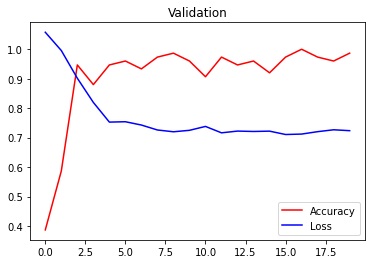

In [ ]:
plt.plot(x, acc_list_val, 'r-', label='Accuracy')
plt.plot(x, loss_list_val, 'b-', label='Loss')
plt.legend()
plt.title('Validation')
plt.show()

Save the best model

In [ ]:
print(best_epoch)

16


# Test the new optimized model

In [ ]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_features,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,3)),
    ('output', nn.Softmax(dim=1))]))
    #Load the trained weights
model.load_state_dict(torch.load('drive/MyDrive/Data LAMA/model-face-recognition-dictFinal3(advModel_batch64).pth', map_location=torch.device('cpu')))
    #Change to eval mode (would be training otherwise)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
img, lbl = next(iter(dataloaders['val']))

#img = img.permute(0, 3, 1, 2)
outputs = model(img)
print('Label:' + str(lbl))
print('Outputs: ' + str(outputs))
value, preds = torch.max(outputs, 1)
#print(loss_function_first(outputs, lbl))
print('Value: ' + str(value))
print('Preds: ' + str(preds))
#print(lbl)
#loss = loss_fct(outputs, lbl)
#print(loss)

Label:tensor([0, 1, 1, 2])
Outputs: tensor([[9.9454e-01, 2.6789e-04, 5.1906e-03],
        [5.6445e-06, 9.9986e-01, 1.3240e-04],
        [5.0932e-05, 9.9812e-01, 1.8250e-03],
        [2.8158e-03, 5.2528e-03, 9.9193e-01]], grad_fn=<SoftmaxBackward>)
Value: tensor([0.9945, 0.9999, 0.9981, 0.9919], grad_fn=<MaxBackward0>)
Preds: tensor([0, 1, 1, 2])
